# Experiment  0 & 1: Assess Model Proactiveness 
How quickly do the models adapt to a new goal once a waypoint is passed?

In [1]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [3]:
def plot_goal_distribution(goal_distribution):
    """
    Plot the goal distribution as a bar plot.

    Parameters
    ----------
    goal_distribution : dict
        Dictionary mapping candidate goal IDs to probability values.
    """
    # Extract goal IDs and probabilities, converting to floats if needed.
    goals = list(goal_distribution.keys())
    probs = [float(goal_distribution[g]) for g in goals]
    
    # Create the bar plot.
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(goals)), probs, tick_label=[str(g) for g in goals])
    plt.xlabel("Candidate Goal IDs")
    plt.ylabel("Probability")
    plt.title("Posterior Distribution over Candidate Goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [4]:
def visualize_map(campus, ax=None):
    """Visualize the campus map.
    
    Args:
        show_landmarks: Whether to highlight landmark nodes
        ax: Optional matplotlib axis to plot on
        
    Returns:
        fig, ax: The figure and axis objects
    """
    if ax is None:
        fig, ax = ox.plot_graph(campus.G, figsize=(15, 15), node_size=5, 
                             edge_color=VISUAL_CONFIG["edge_color"], show=False)
    else:
        # Plot graph on existing axis
        fig = ax.figure
        ox.plot_graph(campus.G, ax=ax, node_size=5, 
                    edge_color=VISUAL_CONFIG["edge_color"], show=False)
    
    # Add buildings
    if campus.buildings is not None:
        campus.buildings.plot(ax=ax, color=VISUAL_CONFIG["building_color"], 
                         alpha=0.7, edgecolor=VISUAL_CONFIG["building_edge"])
    

    # Highligth start nodes
    start_node_1_x = campus.node_coords[start_node_1][0]
    start_node_1_y = campus.node_coords[start_node_1][1]
    
    start_node_2_x = campus.node_coords[start_node_2][0]
    start_node_2_y = campus.node_coords[start_node_2][1]
    
    start_x = [start_node_1_x, start_node_2_x]
    start_y = [start_node_1_y, start_node_2_y]
    ax.scatter(start_x, start_y, 
                 c="red", 
                 s=130, 
                 marker="s",
                 zorder=5, label="Start")

    # Highlight waypoint
    waypoint_node_x = campus.node_coords[waypoint_node][0]
    waypoint_node_y = campus.node_coords[waypoint_node][1]

    ax.scatter(waypoint_node_x, waypoint_node_y, 
                 c="yellow", 
                 s=80, 
                 marker="D",
                 zorder=5, label="Mid-Point Goal")

    # Highlight goal nodes
    goal_node_1_x = campus.node_coords[goal_node_1][0]
    goal_node_1_y = campus.node_coords[goal_node_1][1]
    
    goal_node_2_x = campus.node_coords[goal_node_2][0]
    goal_node_2_y = campus.node_coords[goal_node_2][1]

    goal_x = [goal_node_1_x, goal_node_2_x]
    goal_y = [goal_node_1_y, goal_node_2_y]
    ax.scatter(goal_x, goal_y, 
                 c="green", 
                 s=130, 
                 marker="*",
                 zorder=5, label="Goal")
    
    
    # Only add title and tight_layout if we created a new figure
    if ax is None:
        plt.title("UCSD Campus Environment")
        plt.tight_layout()
    
    return fig, ax

In [5]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
#from real_world_src.simulation.simulator import Simulator
from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color


### Step 1. Draw two agents from similar starting position, same mid-goal, and very different final goal.  
- First, draw two starting nodes from < 3 path length apart.
- Second, draw single waypoint goal > 10 path length away from start
- Third, draw two final goals > 10 from midpoint and > 10 from each other

In [6]:
# Create a run manager
run_manager = RunManager('visuals')
run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Started new simulation run #14
All visualizations will be saved to: /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_14_20250415_100723
Loading map data for University of California, San Diego, La Jolla, CA, USA...
Environment loaded with 3108 nodes and 8646 edges


Get starting nodes

In [7]:
start_node_1 = campus.get_random_node()
cutoff = 3
shortest_path_lengths = nx.single_source_shortest_path_length(campus.G_undirected, start_node_1, cutoff=cutoff)
shortest_path_lengths.pop(start_node_1)
start_node_2 = random.choice(list(shortest_path_lengths.keys()))

Get single waypoint node

In [8]:
# Pick a waypoint node that's reasonably far from start
while True:
    waypoint_node = campus.get_random_node()
    try:
        path = nx.shortest_path(campus.G_undirected, 
                               source=start_node_1, 
                               target=waypoint_node, 
                               weight='length')
        if len(path) > 15:  # Make sure path is non-trivial
            break
    except:
        continue
waypoint_node

9552931566

Get goal nodes

In [9]:
# Pick goal nodes that are (1) far from each other and (2) far from waypoint

while True:
    goal_node_1 = campus.get_random_node()
    goal_node_2 = campus.get_random_node()
    try:
        # Check condition (1)
        check_1 = nx.shortest_path(campus.G_undirected, 
                               source=goal_node_1, 
                               target=goal_node_2, 
                               weight='length')

        # Check condition (2) goal 1
        check_2_goal_1 = nx.shortest_path(campus.G_undirected, 
                               source=goal_node_1, 
                               target=waypoint_node, 
                               weight='length')

        # Check condition (2) goal 2
        check_2_goal_2 = nx.shortest_path(campus.G_undirected, 
                               source=goal_node_2, 
                               target=waypoint_node, 
                               weight='length')
        
        if len(check_1) > 15 and len(check_2_goal_1) > 15 and len(check_2_goal_2) > 15:  # Make sure path is non-trivial
            break
    except:
        continue
goal_node_1, goal_node_2

(658984737, 445989086)

Visualize the selections

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

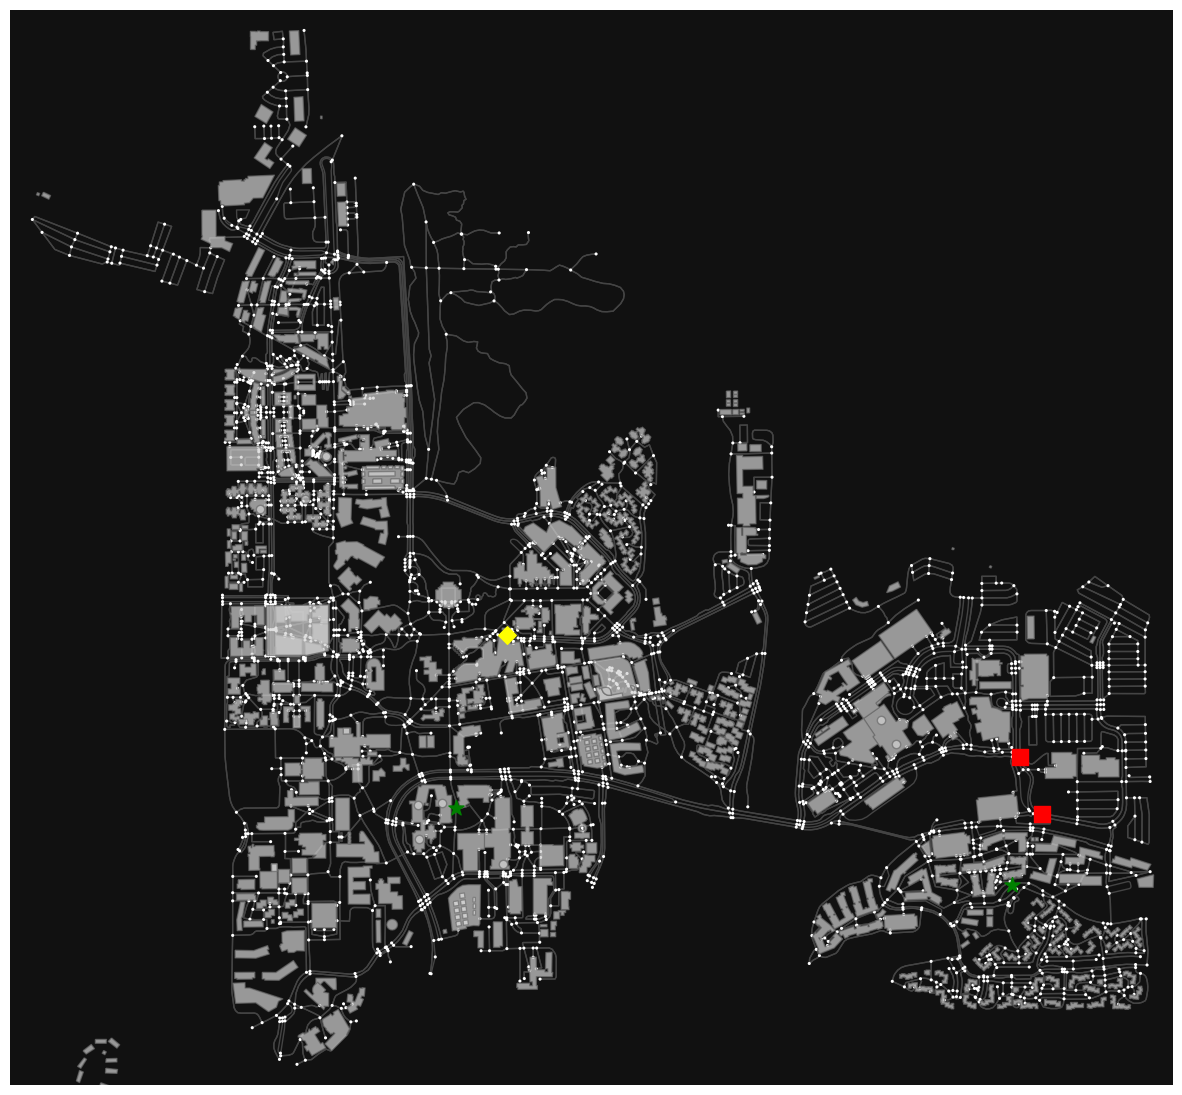

In [10]:
visualize_map(campus)

### Step 2. Define two agents and run full simulation

In [11]:
agent_1 = AgentFactory.create_agent("shortest")
agent_2 = AgentFactory.create_agent("explorer")

# Set the start nodes
agent_1.start_node = start_node_1
agent_2.start_node = start_node_2

# Set the waypoint as the goal for now
agent_1.goal_node = waypoint_node
agent_2.goal_node = waypoint_node

# Add agents to the environment
campus.add_agent(agent_1)
campus.add_agent(agent_2)

agents = [agent_1, agent_2]

Using correct reset
Saving animation to /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_14_20250415_100723/animations/campus_navigation.gif...
All agents have reached their goals!
Animation saved successfully to /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_14_20250415_100723/animations/campus_navigation.gif


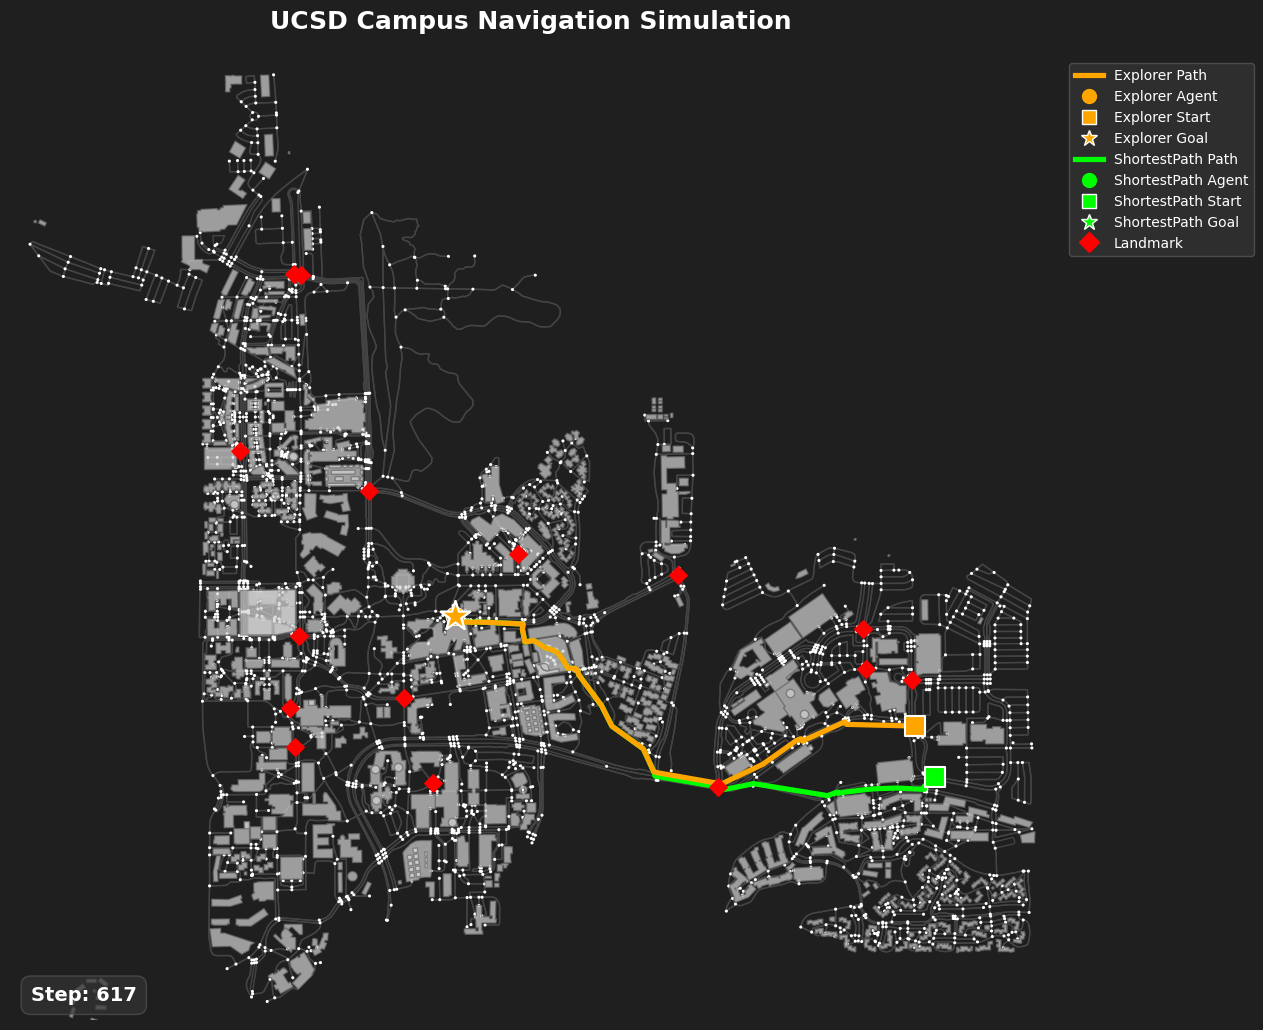

In [12]:
# Create simulator and run
simulator = Simulator(campus, run_manager=run_manager)
simulator.run_simulation(
    max_steps=1000,
    animate=True,
    save_animation=True
)

In [13]:
# Save the initial path to separate lists
a1_path1 = agent_1.path
a2_path1 = agent_2.path

Agents should now continue onto their final goals

In [14]:
# Set the start nodes
agent_1.start_node = waypoint_node
agent_2.start_node = waypoint_node

# Set the waypoint as the goal for now
agent_1.goal_node = goal_node_1
agent_2.goal_node = goal_node_2

Using correct reset
Saving animation to /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_14_20250415_100723/animations/campus_navigation.gif...
All agents have reached their goals!
Animation saved successfully to /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_14_20250415_100723/animations/campus_navigation.gif


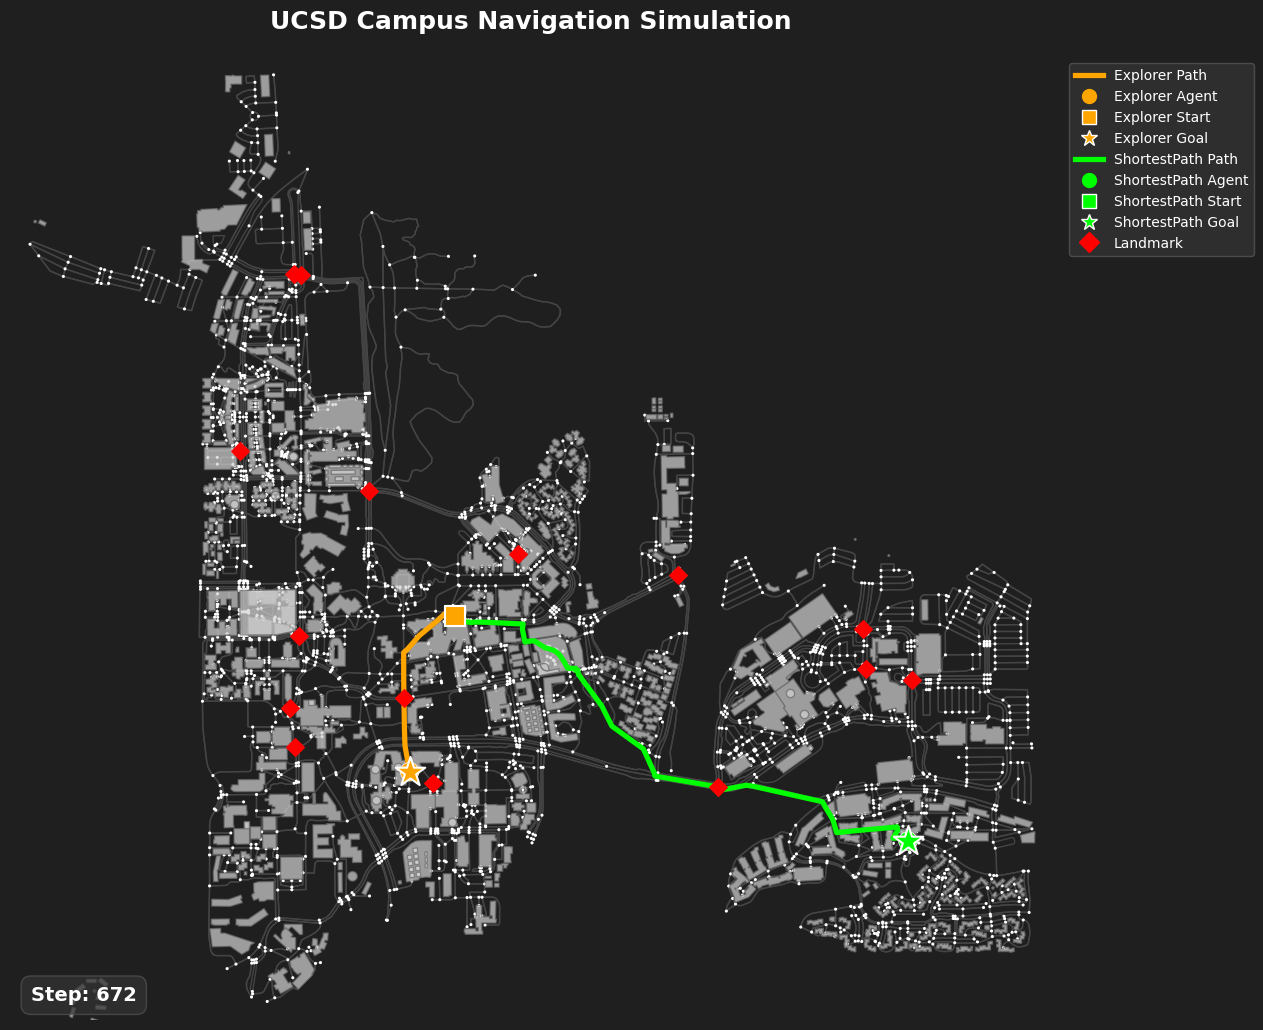

In [15]:
# Create simulator and run
simulator = Simulator(campus, run_manager=run_manager)
simulator.run_simulation(
    max_steps=1000,
    animate=True,
    save_animation=True
)

In [16]:
agent_1.path

[9552931566,
 7180458102,
 9552931573,
 7180458117,
 7180458098,
 10301407421,
 10301407425,
 7180458113,
 9620618679,
 7180458116,
 5983732118,
 4553390952,
 4553390941,
 49721328,
 10553246952,
 12072393886,
 12072393909,
 12072393911,
 12072393915,
 12072393913,
 12072393887,
 12256265400,
 12072393888,
 10553246950,
 10553246948,
 12072377547,
 12072377550,
 12072377548,
 12072377544,
 12072377542,
 9867139424,
 9739748081,
 9867133513,
 9408616471,
 9408616468,
 7179565949,
 7179565954,
 5390812787,
 7179588596,
 4037576308,
 7179588593,
 7237743291,
 7237743290,
 7161923989,
 7161876384,
 9544330409,
 7161876379,
 7249339431,
 5388224308,
 5740082877,
 5740082876,
 5740082879,
 5740071615,
 5388224286,
 5740082883,
 5740082884,
 5390733100,
 5390733101,
 5390733108,
 5390733114,
 5390733109,
 658984737]

### Step 3. Define Metrics

Psuedo-code for metrics:  

def accuracy():  
- For each step in path:
    - Compute the current goal distribution from model --> ToM_Model(agent path)
    - Check whether the highest probability goal matches the correct next goal of the agent
- Measure accuracy for all agents over proportion of their path completed

def confidence():  

- For a given position:
- Measure confidence as the difference between the highest probability goal and the average probablity of the other goals (or should it just be the next biggest probability goal?)
    

In [17]:
# Import BToM baseline
from real_world_src.models.btom import BToM

In [18]:
""" The below is not needed actually. The simulation resets the agent path so 
when we run it the second time to the final goal, only this final path is kept.
"""

# Find the point when agents reach the waypoint
# waypoint_idx_1 = agent_1.path.index(waypoint_node)
# waypoint_idx_2 = agent_2.path.index(waypoint_node)

# Get path for second half of path to final goals
# agent_1_final_path = agent_1.path[waypoint_idx_1:]
# agent_2_final_path = agent_2.path[waypoint_idx_2:]

' The below is not needed actually. The simulation resets the agent path so \nwhen we run it the second time to the final goal, only this final path is kept.\n'

In [19]:
btom = BToM(campus, agents)

Computing shortest paths...
Done


In [21]:
# Initiate new BToM to clear memory
btom = BToM(campus, agents)

# Get max goal for each step
posteriors_a1 = btom.update_agent_posterior_over_path(agent_1)
posteriors_a2 = btom.update_agent_posterior_over_path(agent_2)

Computing shortest paths...
Done


In [22]:
def map_goals_over_path(posteriors):
    """ Calculates the accuracy of the highest probability goal to the true goal of the agent 
    over the course of agent path.

    Args: 
        posteriors: list
            A list of posteriors (dicts) over the entire path

    Returns:
        map_goals: list of ints
    """
    map_goals = []
    for posterior in posteriors:
         map_goals.append(max(posterior, key=posterior.get))

    return map_goals
    
def correct_predictions_over_path(agent, map_goals):
    """ Calculates a binary values 0 or 1 for each map goal along an agent's path. 1 represents correct inferred goal and 
    0 represents incorrect.

    Args:
        map_goals: list of ints
            a list of the map goals at each step of agent path

    Returns:
        inferences: list of binary values
    """
    inferences = []
    for inf_goal in map_goals:
        if inf_goal == agent.goal_node:
            inferences.append(1)
        else:
            inferences.append(0)
    return inferences
    

In [25]:
map_goals_a1 = map_goals_over_path(posteriors_a1)
preds_a1 = correct_predictions_over_path(agent_1, map_goals)

map_goals_a2 = map_goals_over_path(posteriors_a2)
preds_a2 = correct_predictions_over_path(agent_2, map_goals)

In [29]:
preds_a1

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

### Step 4. Measure Performance after Waypoint. 
Apply metrics to agent's path after it reaches its goal

In [28]:
def accuracy(agent_preds):
    """ Calculates the accuracy of goal inference across all agents. 

    Args: 
        agent_preds: list of lists
            Contains the list of prediction correctness (0 or 1) for each agent

    Returns:
        accuracy_over_path: list of accuracy over path
    """
    accuracy_over_path = []
    # Shoot. What do we do when all the path lengths are differnt? Binning? Some average? 